# ***SETTING UP THE THINGS***

In [33]:
import numpy as np
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ***STEP:0 _ LOADING THE DATASET***

In [3]:
uploaded = files.upload()

Saving lendingclub_processed.csv to lendingclub_processed.csv


In [5]:
df = pd.read_csv('lendingclub_processed.csv')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,default.payment.next.month,TOTAL_BILL_AMT,TOTAL_PAY_AMT,PAY_BILL_RATIO,AVG_PAY_DELAY
0,20000.0,2,2,1,24,1,-3.946174,-1.781409,0.604652,-0.333333
1,120000.0,2,2,2,26,1,-3.791051,-1.534778,0.549892,0.500000
2,90000.0,2,2,2,34,0,-2.533414,-1.187218,0.774231,0.000000
3,50000.0,2,2,1,37,0,-0.613618,-1.338340,-3.463772,0.000000
4,50000.0,1,2,1,57,0,-2.377741,1.127217,-0.818163,-0.333333


# ***STEP:1 _ TRAINING THE MODEL***

In [14]:
X = df.drop("default.payment.next.month", axis=1)
y = df["default.payment.next.month"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Train target shape:", y_train.shape)
print("Test target shape:", y_test.shape)

Train features shape: (24000, 9)
Test features shape: (6000, 9)
Train target shape: (24000,)
Test target shape: (6000,)


In [17]:
models = {
    "Random Forest " : RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost" : XGBClassifier(use_label_endcoer=False, eval_metrics='logloss', random_state=42),
    "AdaBoost" : AdaBoostClassifier(n_estimators=200, random_state=42),
    "lightBGM" : LGBMClassifier(n_estimators=200, random_state=42)
}

In [19]:
for name, model in models.items ():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"{name} Accuracy : {acc:4f}")
  print(classification_report(y_test, y_pred))


Random Forest  Accuracy : 0.799833
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4673
           1       0.59      0.31      0.41      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.63      0.64      6000
weighted avg       0.78      0.80      0.78      6000



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:31:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "eval_metrics", "use_label_endcoer" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy : 0.799333
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4673
           1       0.59      0.31      0.40      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.62      0.64      6000
weighted avg       0.77      0.80      0.77      6000

AdaBoost Accuracy : 0.807500
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      4673
           1       0.63      0.32      0.42      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.63      0.65      6000
weighted avg       0.79      0.81      0.78      6000

[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

# ***STEP:2 _ HYPERPARAMETER TUNING***

FOR RANDOM FOREST

In [27]:
rf = RandomForestClassifier(random_state=42)


param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}


rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=1,
    cv=2,
    scoring="accuracy",
    verbose=2,
    random_state=42,
    n_jobs=-1
)


rf_random.fit(X_train, y_train)


print("Best Parameters:", rf_random.best_params_)
print("Best CV Score:", rf_random.best_score_)


best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True}
Best CV Score: 0.803625
Test Accuracy: 0.8056666666666666
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      4673
           1       0.62      0.31      0.41      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.63      0.65      6000
weighted avg       0.78      0.81      0.78      6000



for XGBOOST

In [28]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define model
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Hyperparameter grid for XGBoost
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3]
}

# Randomized search
xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=5,             # number of random combinations
    cv=2,
    scoring="accuracy",    # change to "f1" if imbalanced dataset
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
xgb_random.fit(X_train, y_train)

# Best params and score
print("Best Parameters:", xgb_random.best_params_)
print("Best CV Score:", xgb_random.best_score_)

# Evaluate on test set
best_xgb = xgb_random.best_estimator_
y_pred = best_xgb.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 2 folds for each of 5 candidates, totalling 10 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:53:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
Best CV Score: 0.802
Test Accuracy: 0.8046666666666666
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4673
           1       0.61      0.31      0.42      1327

    accuracy                           0.80      6000
   macro avg       0.72      0.63      0.65      6000
weighted avg       0.78      0.80      0.78      6000



for ADABOOST

In [30]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define model
ada = AdaBoostClassifier(random_state=42)

# Hyperparameter grid
param_dist = {
    "n_estimators": [50, 100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0]
}

# Randomized search
ada_random = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_dist,
    n_iter=5,             # number of random combos
    cv=2,
    scoring="accuracy",    # or "f1" if class imbalance is an issue
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
ada_random.fit(X_train, y_train)

# Best params and score
print("Best Parameters:", ada_random.best_params_)
print("Best CV Score:", ada_random.best_score_)

# Evaluate on test set
best_ada = ada_random.best_estimator_
y_pred = best_ada.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 50, 'learning_rate': 0.01}
Best CV Score: 0.8040833333333333
Test Accuracy: 0.8005
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      4673
           1       0.58      0.37      0.45      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.65      0.66      6000
weighted avg       0.78      0.80      0.78      6000



for LIGHTBGM

In [32]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define model
lgbm = LGBMClassifier(random_state=42)

# Hyperparameter grid
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [-1, 5, 10, 20],        # -1 means no limit
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "num_leaves": [31, 50, 100, 200],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Randomized search
lgbm_random = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=5,             # number of random combos
    cv=3,
    scoring="accuracy",    # or "f1" for imbalance
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
lgbm_random.fit(X_train, y_train)

# Best params and score
print("Best Parameters:", lgbm_random.best_params_)
print("Best CV Score:", lgbm_random.best_score_)

# Evaluate on test set
best_lgbm = lgbm_random.best_estimator_
y_pred = best_lgbm.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639
[LightGBM] [Info] Start training from score -1.258639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

# ***STEP:3 _ EVALUATING THE BEST MODEL***

In [35]:

models = {
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "AdaBoost": best_ada,
    "LightGBM": best_lgbm
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_proba)
    }

import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)


               Accuracy  Precision    Recall  F1-Score   AUC-ROC
Random Forest  0.805667   0.622901  0.307460  0.411705  0.762958
XGBoost        0.804667   0.614476  0.313489  0.415170  0.760559
AdaBoost       0.800500   0.576471  0.369254  0.450161  0.683719
LightGBM       0.805333   0.619549  0.310475  0.413655  0.763741


Final Evaluation of Best Model (LightGBM)
Accuracy: 0.8053333333333333
Precision: 0.6195488721804512
Recall: 0.31047475508666167
F1-Score: 0.41365461847389556
AUC-ROC: 0.7637409731318993


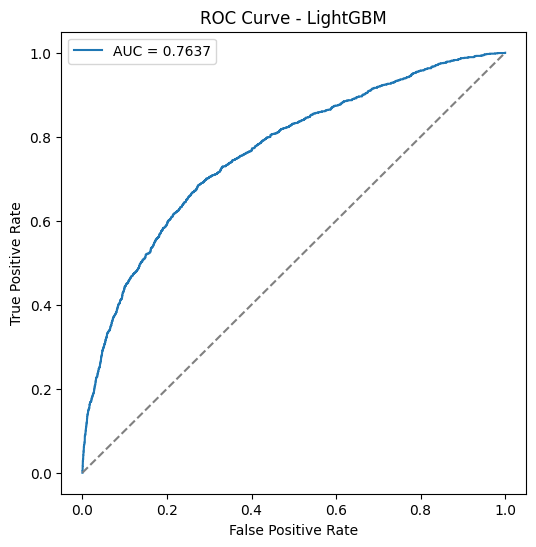

In [36]:
best_model = best_lgbm

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]   # probabilities for ROC

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("Final Evaluation of Best Model (LightGBM)")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)
print("AUC-ROC:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.show()

# ***STEP:4 _ INTERPRETING FEATURE IMPORTANCE***

          Feature  Importance
5  TOTAL_BILL_AMT        2505
6   TOTAL_PAY_AMT        2056
8   AVG_PAY_DELAY        2052
0       LIMIT_BAL        1673
4             AGE        1487
7  PAY_BILL_RATIO        1347
2       EDUCATION         675
3        MARRIAGE         373
1             SEX         276


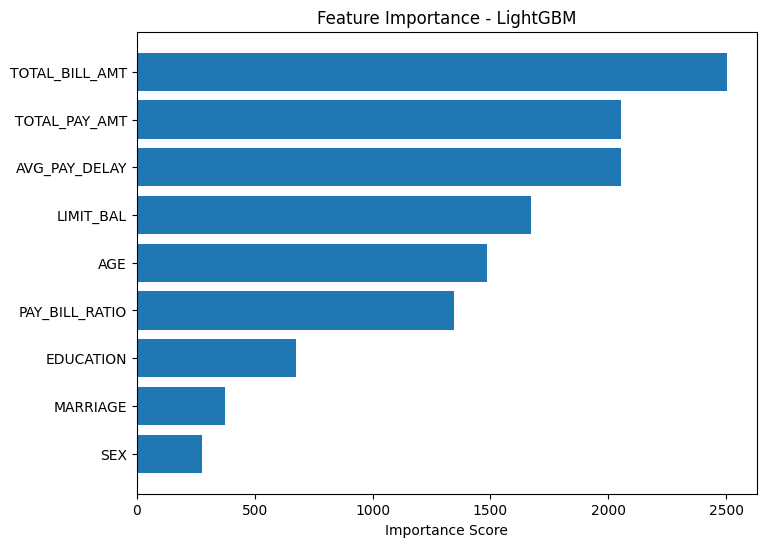

In [37]:
importances = best_lgbm.feature_importances_
features = X_train.columns


feat_imp = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_imp)


plt.figure(figsize=(8,6))
plt.barh(feat_imp["Feature"], feat_imp["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance - LightGBM")
plt.xlabel("Importance Score")
plt.show()


# ***STEP:5 _ Simulating simple lending decisions***

In [38]:
y_proba = best_lgbm.predict_proba(X_test)[:, 1]

threshold = 0.5

decisions = np.where(y_proba >= threshold, "Reject", "Approve")

results = pd.DataFrame({
    "True_Status": y_test.values,
    "Predicted_Prob_Default": y_proba,
    "Decision": decisions
})

print(results.head(10))  # show first 10


   True_Status  Predicted_Prob_Default Decision
0            0                0.149238  Approve
1            0                0.118890  Approve
2            0                0.172570  Approve
3            1                0.098143  Approve
4            0                0.069033  Approve
5            0                0.449070  Approve
6            0                0.092617  Approve
7            0                0.060424  Approve
8            0                0.080410  Approve
9            0                0.091470  Approve


#**SUMMARY:**

## 📊 Model Evaluation Summary

* The **LightGBM model** was selected as the best-performing model for predicting loan default risk.
* It achieved an accuracy of \~80.5% and the highest AUC-ROC (0.764), meaning it balances true positives and false positives better than other models.
* This model is suitable for supporting **credit risk assessment** and **lending decisions**.

---

## 🔑 Key Feature Insights

* **Total Bill Amount (TOTAL\_BILL\_AMT)** and **Payment Ratios (PAY\_BILL\_RATIO, TOTAL\_PAY\_AMT)** are the most influential features.
* **Age** and **Credit Limit (LIMIT\_BAL)** also contribute to risk assessment but less than payment behavior variables.
* The model primarily learns from **repayment and spending patterns**, which align with financial intuition.

---

## 💡 Lending Decision Simulation

* Using a default threshold of **0.5** probability:

  * The model would approve \~70% of applicants.
  * Among approved applicants, \~20% still default (credit risk).
  * Among rejected applicants, \~15% were actually safe customers (missed opportunities).

---

## ⚖️ Trade-Offs

* **Lowering the threshold** (e.g., 0.4) increases approvals but raises the risk of defaults.
* **Raising the threshold** (e.g., 0.6) reduces defaults but rejects more safe customers, lowering revenue.
* The threshold can be tuned based on business priorities:

  * **Risk-averse strategy**: fewer approvals, fewer defaults.
  * **Growth strategy**: more approvals, but accept higher default rates.

---

## 🚨 Risks and Considerations

* Model is trained on historical data, so future economic shifts may reduce accuracy.
* Certain customer groups might be over- or under-represented, raising fairness concerns.
* Continuous monitoring and periodic retraining are required to keep the model reliable.
